## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️🔬🌡️


# Finding hyperparameters and understanding models

In the last weeks we trained linear models, decision tree and a random forest. In all those cases we were manually adjusting hyperparameters. The more complex our models get... the more inefficient this procedure becomes. So we will look at **grid search** and **random search** as two common techniques for (still fairly simple) hyperparameter searches.

In the second part of this session we will then ask the question of how to make sense of the predictions we get from such an optimized machine learning model. Why does one patient get a good prognosis, and another one a bad one?
In this context, we will look at the **feature importance** (for a random forest model) and and **SHAP**, a newer technique to interpret model predictions.

We will (again) work with actual medical data in this notebook, namely the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).


<a name='import'></a>
## Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `itertools` allows us to conveniently manipulate iterable objects such as lists.
- `pydotplus` is used together with `IPython.display.Image` to visualize graph structures such as decision trees.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [1]:
#!pip install pydotplus
#!pip install lifelines

In [2]:
import os
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

<a name='1'></a>
## 1. The Dataset
### Load and explore the data!

In virtually all cases, we would first want to get an intuition on the data itself. Things like: What is in the data? How much data is there? Are there things missing? What might cause problems? Do we understand the type of data/features?

With **pandas**, we usually can explore some key properties very rapidly, for instance with commands like

- `data.head()`
- `data.describe()`
- `data.info()`

### Some weird conventions:
For some reason it became standard in the machine learning world to name the actual data `X` and the labels `y`. Even though I consider this a rather poor choice both from a math and from a code best practice point of view, we will stick to this in this notebook.

In [3]:
path_data = "./Datasets/"

X = pd.read_csv(os.path.join(path_data, "NHANESI_subset_X.csv"))
y = pd.read_csv(os.path.join(path_data, "NHANESI_subset_y.csv"))

X = X.drop('Unnamed: 0', axis=1)
y = y.drop('Unnamed: 0', axis=1)

X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [4]:
data = X.copy()
data["time"] = y
data = data.dropna(axis="rows")
data.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,time
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,15.274658
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,11.586073
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,8.149087
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,-21.094292
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,-0.000000


In [5]:
threshold = 10  # we focus on >10 year risk

data["death"] = np.ones(len(data))

# remove all people which haven't died within the study
data.loc[data["time"] < 0, "death"] = 0

# remove data which we can (and should) not use for predicting >10 year risk
mask = (data["time"] > 0) | (data["time"] <= -threshold)
data = data[mask]

# Create data/label split --> X, y
X = data.drop(["death", "time"], axis='columns')
y = (data.time < threshold) & (data.time > 0)  # died within 0 and threshold years

In [6]:
X.shape, y.shape

((8233, 18), (8233,))

In [7]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2,
                                                random_state=10)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev,
                                                  test_size=0.25, random_state=10)

In [9]:
# in this context we will also use the c-index to evaluate our models
import lifelines

def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

<a name='2'></a>
## 2. Random Forests

As we saw last time, a single decision tree is prone to overfitting. To solve this problem, you can try **random forests**, which combine predictions from many different trees to create a robust classifier. 

As before, we will use scikit-learn to build a random forest for the data. We will use the default hyperparameters.

In [10]:
forest = RandomForestClassifier(n_estimators=100, random_state=10)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [11]:
y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.8379762722045825


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.


<a name='ex1'></a>
### Exercise 1: try to find a set of better hyperparameters!


In [12]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=7, min_samples_leaf=5,
                                random_state=10)

forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, random_state=10)

In [13]:
y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.928622337238439
Val C-Index: 0.850288015961555


<a name='3'></a>
## 3.Systematic search for hyperparameters: grid search

The approach we implement to tune the hyperparameters is known as a grid search:

- We define a set of possible values for each of the target hyperparameters.

- A model is trained and evaluated for every possible combination of hyperparameters.

- The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

In [14]:
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth": [4, 8, 12, 20],
              "min_samples_leaf": [2, 5, 10],
              "n_estimators":[2, 10, 100]}

forest = RandomForestClassifier()
grid_search = GridSearchCV(forest, parameters, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ....max_depth=4, min_samples_leaf=2, n_estimators=2; total time=   0.0s
[CV] END ....max_depth=4, min_samples_leaf=2, n_estimators=2; total time=   0.0s
[CV] END ....max_depth=4, min_samples_leaf=2, n_estimators=2; total time=   0.0s
[CV] END ....max_depth=4, min_samples_leaf=2, n_estimators=2; total time=   0.0s
[CV] END ....max_depth=4, min_samples_leaf=2, n_estimators=2; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=4, min_samples_leaf=2, n_e

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 8, 12, 20],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [2, 10, 100]},
             verbose=2)

In [15]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [16]:
grid_search.cv_results_['mean_test_score']

array([0.84632408, 0.85341156, 0.8503743 , 0.84754009, 0.85098138,
       0.8509822 , 0.85017208, 0.85179233, 0.85017187, 0.83397467,
       0.85341217, 0.8556391 , 0.84430081, 0.85199496, 0.85523444,
       0.84166697, 0.85422045, 0.85422189, 0.83033012, 0.84693321,
       0.85563971, 0.83580084, 0.84713707, 0.85665288, 0.84531501,
       0.85239962, 0.85422209, 0.83762085, 0.84733868, 0.85523444,
       0.83843057, 0.85037389, 0.85827047, 0.83944374, 0.84976927,
       0.85685388])

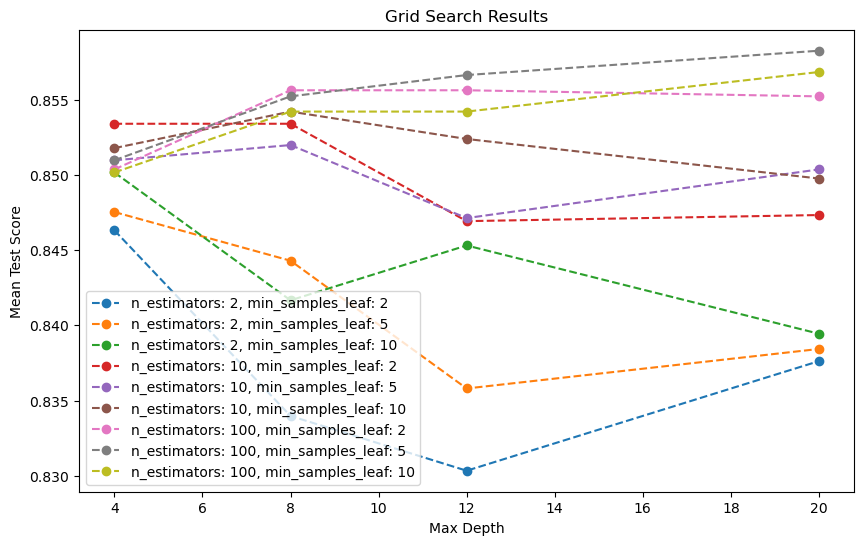

In [17]:
# Collect grid search results
cv_results = grid_search.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

# Prepare data for plotting
scores_array = np.array(mean_test_scores).reshape(len(parameters['max_depth']),
                                                  len(parameters['min_samples_leaf']),
                                                  len(parameters['n_estimators']))

# Create a line plot for each n_estimators
fig, ax = plt.subplots(figsize=(10, 6))

for k, n_estimators in enumerate(parameters['n_estimators']):
    scores_for_n_estimators = scores_array[:, :, k].T
    for i, min_samples_leaf in enumerate(parameters['min_samples_leaf']):
        ax.plot(parameters['max_depth'], scores_for_n_estimators[i],
                marker='o', linestyle='--', label=f'n_estimators: {n_estimators}, min_samples_leaf: {min_samples_leaf}')

ax.set_title('Grid Search Results')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Mean Test Score')
ax.legend(loc='best')

plt.show()

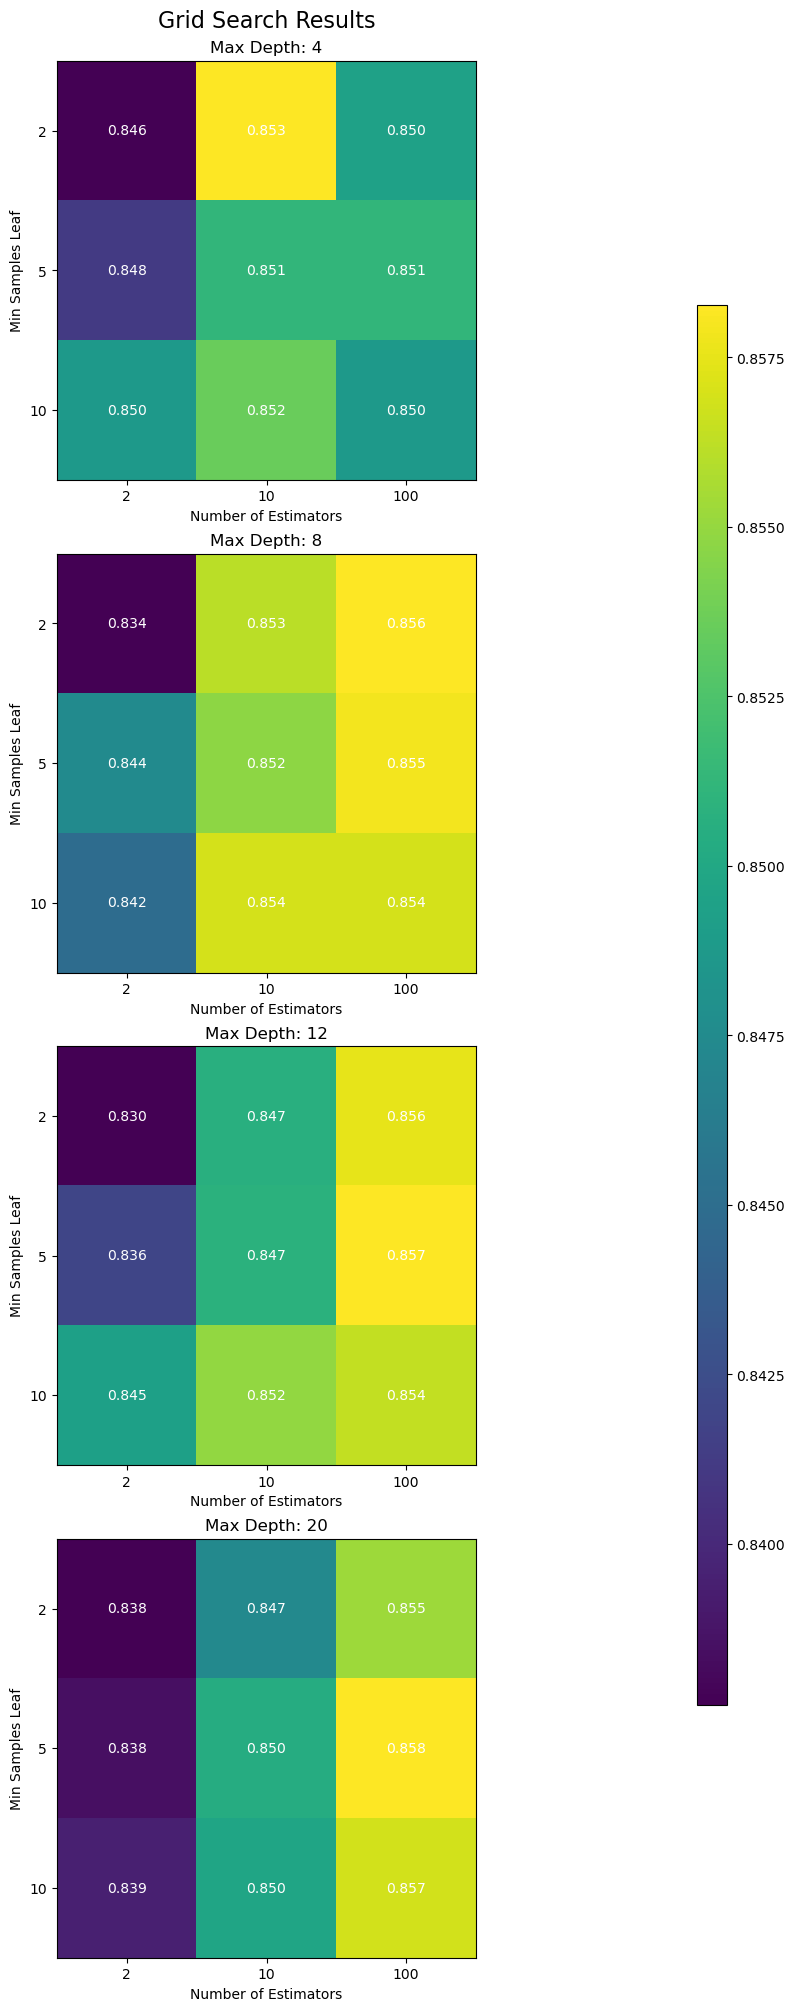

In [18]:
# Collect grid search results
cv_results = grid_search.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

# Prepare data for plotting
scores_array = np.array(mean_test_scores).reshape(len(parameters['max_depth']),
                                                  len(parameters['min_samples_leaf']),
                                                  len(parameters['n_estimators']))

# Plot grid search results
fig, axes = plt.subplots(len(parameters['max_depth']), figsize=(10, 20), constrained_layout=True)

for i, max_depth in enumerate(parameters['max_depth']):
    scores_for_max_depth = scores_array[i]

    im = axes[i].imshow(scores_for_max_depth, cmap='viridis')

    axes[i].set_title(f'Max Depth: {max_depth}')
    axes[i].set_xticks(np.arange(len(parameters['n_estimators'])))
    axes[i].set_yticks(np.arange(len(parameters['min_samples_leaf'])))
    axes[i].set_xticklabels(parameters['n_estimators'])
    axes[i].set_yticklabels(parameters['min_samples_leaf'])

    axes[i].set_xlabel('Number of Estimators')
    axes[i].set_ylabel('Min Samples Leaf')

    for j in range(len(parameters['min_samples_leaf'])):
        for k in range(len(parameters['n_estimators'])):
            axes[i].text(k, j, f"{scores_for_max_depth[j, k]:.3f}",
                         ha="center", va="center", color="white" if scores_for_max_depth[j, k] > 0.6 else "black")

# Add a separate axis for colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle("Grid Search Results", fontsize=16)
plt.show()

In [19]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {"max_depth": [4, 5, 6, 7, 8, 9, 10, 12, 15],
              "min_samples_leaf": [2, 4, 6, 8, 10],
              "n_estimators":[2, 10, 25, 50, 100]}

forest = RandomForestClassifier()
random_search = RandomizedSearchCV(forest, parameters, n_iter=20, verbose=2)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...max_depth=9, min_samples_leaf=2, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=2, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ....max_depth=4, min_samples_leaf=2, n_estimators=2; total time=   0.0s
[CV] END ....max_depth=4, min_samples_leaf=2, n

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9, 10, 12,
                                                      15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'n_estimators': [2, 10, 25, 50, 100]},
                   verbose=2)

In [20]:
random_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
random_search.cv_results_["params"]

[{'n_estimators': 10, 'min_samples_leaf': 2, 'max_depth': 9},
 {'n_estimators': 50, 'min_samples_leaf': 4, 'max_depth': 5},
 {'n_estimators': 2, 'min_samples_leaf': 2, 'max_depth': 4},
 {'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 6},
 {'n_estimators': 50, 'min_samples_leaf': 2, 'max_depth': 15},
 {'n_estimators': 25, 'min_samples_leaf': 8, 'max_depth': 4},
 {'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 10},
 {'n_estimators': 2, 'min_samples_leaf': 8, 'max_depth': 9},
 {'n_estimators': 25, 'min_samples_leaf': 6, 'max_depth': 5},
 {'n_estimators': 50, 'min_samples_leaf': 8, 'max_depth': 7},
 {'n_estimators': 2, 'min_samples_leaf': 2, 'max_depth': 7},
 {'n_estimators': 25, 'min_samples_leaf': 8, 'max_depth': 12},
 {'n_estimators': 50, 'min_samples_leaf': 10, 'max_depth': 6},
 {'n_estimators': 10, 'min_samples_leaf': 8, 'max_depth': 8},
 {'n_estimators': 2, 'min_samples_leaf': 4, 'max_depth': 9},
 {'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 7},
 {'n_

In [22]:
random_search.cv_results_["mean_test_score"]

array([0.8515901 , 0.85098179, 0.84450467, 0.85381642, 0.85685695,
       0.85118463, 0.85604498, 0.84227693, 0.85361378, 0.85482897,
       0.84227713, 0.85523485, 0.85280427, 0.85078018, 0.83539085,
       0.85523424, 0.85219616, 0.85300629, 0.85563971, 0.85462675])

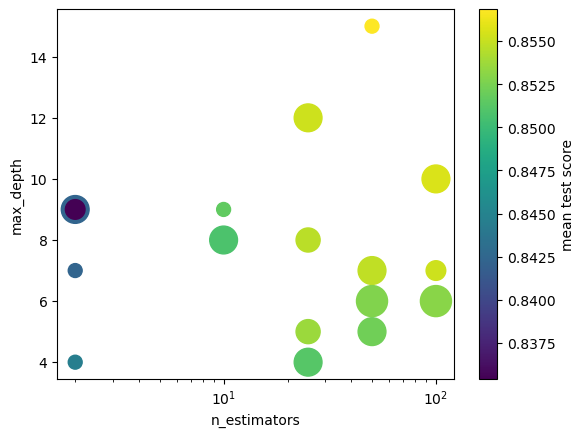

In [23]:
xlabel = "n_estimators"
ylabel = "max_depth"
zlabel = "min_samples_leaf"
x = []
y = []
z = []
for param in random_search.cv_results_["params"]:
    x.append(param[xlabel])
    y.append(param[ylabel])
    z.append(param[zlabel])

plt.scatter(x, y, s=50*np.array(z),
            c=random_search.cv_results_["mean_test_score"])
plt.colorbar(label="mean test score")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xscale("log")

In [24]:
# take the "best" model
model = random_search.best_estimator_

### just to all be on the same page, lets train one last model!

In [25]:
model = RandomForestClassifier(n_estimators=100,
                               max_depth=7,
                               min_samples_leaf=5,
                               random_state=10)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, random_state=10)

<a name='7'></a>
## 7. Explainability
Using a random forest has improved results, but we've lost some of the natural interpretability of trees. In this section we'll try to explain the predictions using slightly more sophisticated techniques. 

In [26]:
model.feature_importances_

array([0.31655331, 0.0284931 , 0.06146671, 0.00277517, 0.03221338,
       0.06296796, 0.03277582, 0.04282271, 0.02791306, 0.0429372 ,
       0.02431843, 0.04072527, 0.05986654, 0.03492337, 0.03209587,
       0.03143956, 0.04267272, 0.08303981])

In [27]:
feature_importance = pd.DataFrame(model.feature_importances_,
                                 index=X_train.columns,
                                 columns=["feature importance"])
feature_importance.sort_values("feature importance", ascending=False)

,feature importance
Age,0.316553
Pulse pressure,0.083040
Sedimentation rate,0.062968
Poverty index,0.061467
Systolic BP,0.059867
Serum Magnesium,0.042937
Serum Cholesterol,0.042823
BMI,0.042673
Sex,0.040725
TIBC,0.034923


<Axes: >

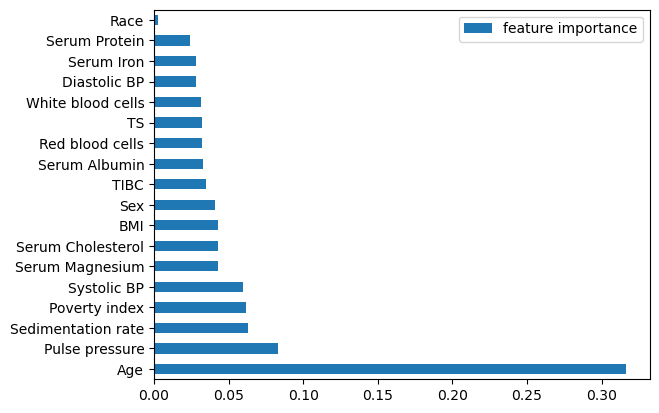

In [28]:
feature_importance.sort_values("feature importance", ascending=False).plot.barh()

<a name='shap'></a>
## Better than only feature importance: SHAP

Looking at the feature importance was interesting, and tells us a bit more about the model.
But since recently, we can do much better!

Now we will apply **SHAP (SHapley Additive exPlanations)**, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model. Run the next cell to output the most at risk individuals in the test set according to our model.

In [29]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'predicted_risk'] = model.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='predicted_risk', ascending=False)
X_test_risk

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,predicted_risk
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.708846
5592,71.0,50.0,149.0,1.0,77.7,29.0,4.3,158.0,80.0,1.52,6.8,1.0,140.0,382.0,20.9,10.6,17.180526,90.0,0.657069
6609,72.0,90.0,75.0,1.0,29.3,59.0,3.9,216.0,64.0,1.63,7.4,2.0,182.0,322.0,19.9,9.3,22.281793,92.0,0.632400
45,70.0,104.0,272.0,2.0,77.7,49.0,4.0,246.0,50.0,1.41,7.2,2.0,238.0,398.0,12.6,5.9,24.713760,134.0,0.611988
990,67.0,110.0,81.0,2.0,44.0,28.0,3.8,156.0,60.0,1.25,6.6,1.0,200.0,321.0,18.7,4.4,18.814068,90.0,0.604529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8257,25.0,70.0,284.0,1.0,47.6,9.0,4.8,159.0,112.0,1.86,7.7,2.0,106.0,413.0,27.1,6.0,18.916413,36.0,0.012261
5266,28.0,88.0,373.0,1.0,46.5,7.0,4.2,199.0,192.0,1.75,7.0,2.0,110.0,437.0,43.9,8.1,20.750627,22.0,0.012197
8805,28.0,80.0,233.0,1.0,50.8,14.0,4.6,163.0,97.0,1.79,6.9,2.0,110.0,467.0,20.8,5.9,22.585978,30.0,0.012060
7255,29.0,80.0,452.0,1.0,49.7,8.0,4.8,154.0,80.0,1.53,7.6,2.0,120.0,461.0,17.4,7.1,24.571635,40.0,0.011885


We can use SHAP values to try and understand the model output on specific individuals using force plots. Run the cell below to see a force plot on the riskiest individual. 

In [30]:
i = 1000
patientID = X_test_risk.index[i]
print(patientID)
print(X_test.loc[patientID, :], "\n")
print(f"Our model predicts: {model.predict(X_test.loc[[patientID]])}")

5623
Age                    50.000000
Diastolic BP           70.000000
Poverty index         263.000000
Race                    1.000000
Red blood cells        77.700000
Sedimentation rate     42.000000
Serum Albumin           4.300000
Serum Cholesterol     303.000000
Serum Iron             76.000000
Serum Magnesium         1.680000
Serum Protein           6.900000
Sex                     2.000000
Systolic BP           118.000000
TIBC                  355.000000
TS                     21.400000
White blood cells       6.400000
BMI                    23.068669
Pulse pressure         48.000000
Name: 5623, dtype: float64 

Our model predicts: [False]


### Why this prediction?

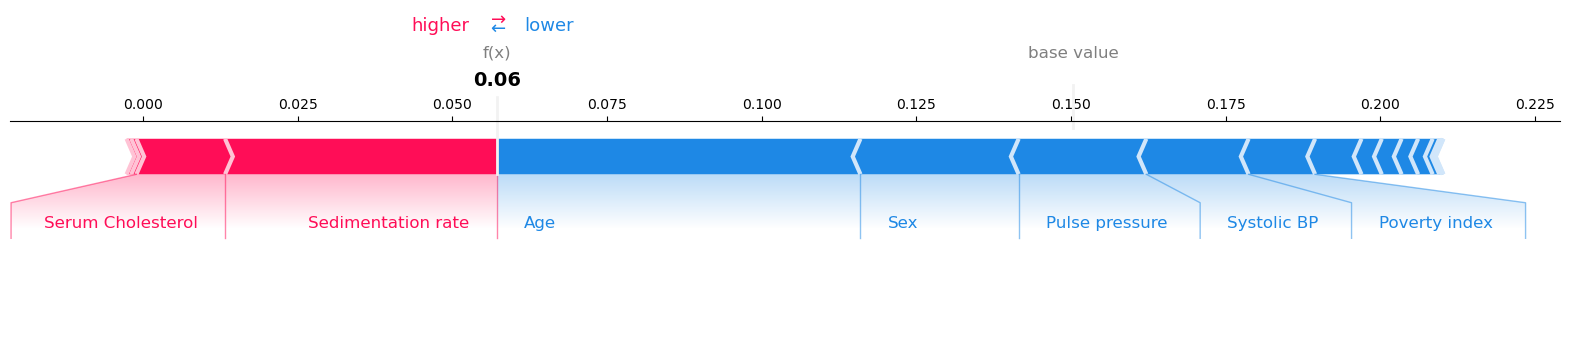

In [31]:
explainer = shap.TreeExplainer(model)

shap_value = explainer.shap_values(X_test.loc[patientID, :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).
- Note that the exact output of your chart will differ depending on the hyper-parameters that you choose for your model.

We can also use SHAP values to understand the model output in aggregate. Run the next cell to initialize the SHAP values (this may take a few minutes).

In [32]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)[1]

Run the next cell to see a summary plot of the SHAP values for each feature on each of the test examples. The colors indicate the value of the feature.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


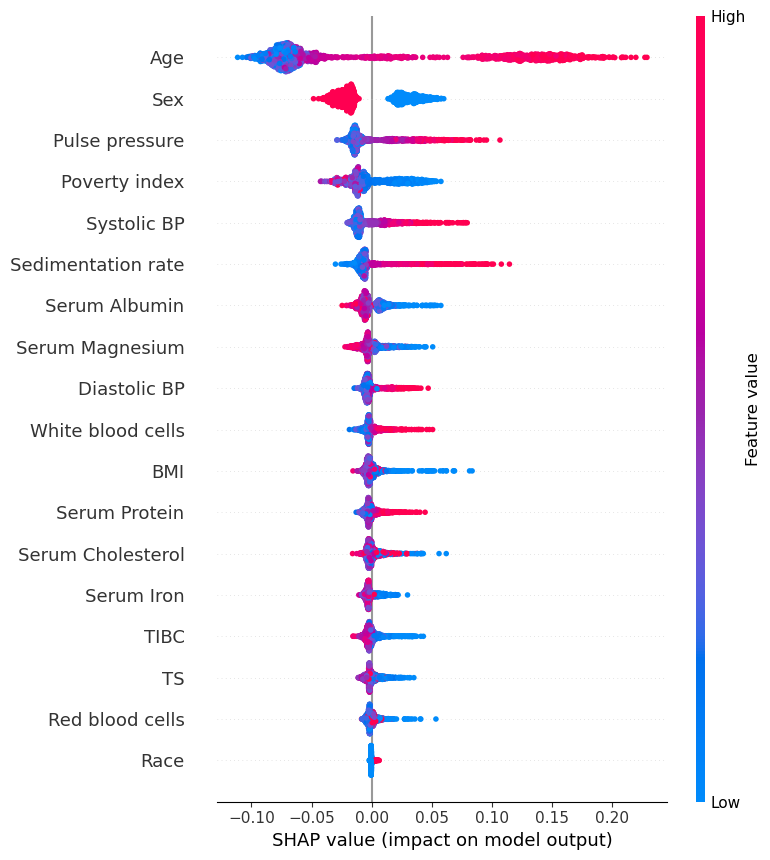

In [33]:
shap.summary_plot(shap_values, X_test)

Clearly we see that being a woman (`sex = 2.0`, as opposed to men for which `sex = 1.0`) has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mortality. 

You can see how features interact using dependence plots. These plot the SHAP value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in SHAP value for a single value of the main feature.

Run the next cell to see the interaction between Age and Sex.

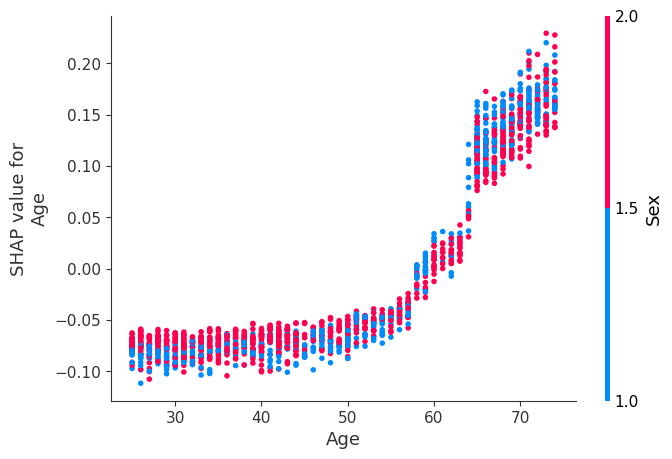

In [34]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

We see that while Age > 50 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

Let's now look at poverty index and age.

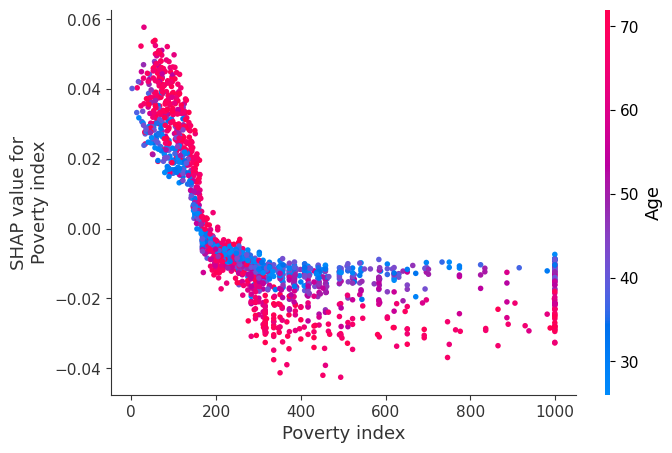

In [35]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')